In [53]:
import sys
import itertools
from pathlib import Path
from addict import Dict

sys.path.append('../../')

In [32]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit

from examples.utils.config import Config
from examples.utils.dataset_adapters import retina_dataset
from spikebench import TrainNormalizeTransform
from spikebench.utils import simple_undersampling
from spikebench.mpladeq import prettify, beautify_mpl, boxplot

from sklearn.ensemble import RandomForestClassifier
from pyts.classification import BOSSVS, SAXVSM
from pyts.transformation import ROCKET

beautify_mpl()

In [23]:
config_dict = {
    'seed': 0,
    'window': 50,
    'step': 50,
    'train_subsample_factor': 0.7,
    'test_subsample_factor': 0.7,
    'delimiter': None,
    'dataset': '../../data/retina/mode_paper_data',
    'fstate': 'randomly_moving_bar',
    'mstate': 'white_noise_checkerboard',
}

config = Config(config_dict)
np.random.seed(config.seed)

In [24]:
retinal_spike_data = retina_dataset(config.dataset)

In [25]:
group_split = GroupShuffleSplit(n_splits=1, test_size=0.5)
X = np.hstack(
    [
        retinal_spike_data[config.fstate].series.values,
        retinal_spike_data[config.mstate].series.values,
    ]
)
y = np.hstack(
    [
        np.ones(retinal_spike_data[config.fstate].shape[0]),
        np.zeros(retinal_spike_data[config.mstate].shape[0]),
    ]
)
groups = np.hstack(
    [
        retinal_spike_data[config.fstate].groups.values,
        retinal_spike_data[config.mstate].groups.values,
    ]
)

In [26]:
for train_index, test_index in group_split.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

X_train = pd.DataFrame({'series': X_train, 'groups': groups[train_index]})
X_test = pd.DataFrame({'series': X_test, 'groups': groups[test_index]})

In [27]:
normalizer = TrainNormalizeTransform(
    window=config.window, 
    step=config.step, 
    n_samples=None
)
X_train, y_train = normalizer.transform(X_train, y_train, delimiter=config.delimiter)
X_test, y_test = normalizer.transform(X_test, y_test, delimiter=config.delimiter)

In [28]:
print('Dataset size: train {}, test {}'.format(X_train.shape, X_test.shape))
print('Average target: train {}, test {}'.format(y_train.mean(), y_test.mean()))

Dataset size: train (23187, 50), test (23908, 50)
Average target: train 0.7639194376159054, test 0.7755144721432157


In [29]:
def eval_classifier_scores(models_dict, X_train, X_test, y_train, y_test, config):
    scores = {}

    X_train, y_train = simple_undersampling(
        X_train, y_train, 
        subsample_size=config.train_subsample_factor
    )
    X_test, y_test = simple_undersampling(
        X_test, y_test, 
        subsample_size=config.test_subsample_factor
    )

    for model_name, model in models_dict.items():
        print('Training {} model'.format(model_name))
        model.fit(X_train, y_train)
        print('Evaluating {} model'.format(model_name))
        acc_score = accuracy_score(y_test, model.predict(X_test))
        scores[model_name] = {'acc': acc_score}

    return scores

In [38]:
from sklearn.base import BaseEstimator, ClassifierMixin

class ROCKETClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_extractor=None, classifier=None):
        self.feature_extractor = feature_extractor
        self.classifier = classifier

    def fit(self, X, y):
        X_ = self.feature_extractor.fit_transform(X)
        self.classifier.fit(X_, y)
        return self

    def predict(self, X):
        X_ = self.feature_extractor.transform(X)
        return self.classifier.predict(X_)

In [39]:
num_trials = 10

models_dict = {
    'BOSS-VS': BOSSVS(window_size=30),
    'SAX-VSM': SAXVSM(window_size=20, sublinear_tf=False, use_idf=False),
    'ROCKET-RF': ROCKETClassifier(feature_extractor=ROCKET(n_kernels=500, random_state=42),
                                  classifier=RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
    # 'Shapelets': LearningShapelets(random_state=0, tol=0.1),
}

classifier_scores = Dict()
for model_name in models_dict:
    classifier_scores[model_name].acc = []
    
for trial_idx in range(num_trials):
    print('Running trial # ', trial_idx)
    scores = eval_classifier_scores(models_dict, pd.DataFrame(X_train), pd.DataFrame(X_test), 
                                    y_train, y_test, config)
    for model_name in scores:
        classifier_scores[model_name].acc.append(scores[model_name]['acc'])    

Training BOSS-VS model
Evaluating BOSS-VS model
Training SAX-VSM model
Evaluating SAX-VSM model
Training ROCKET-RF model
Evaluating ROCKET-RF model
Training BOSS-VS model
Evaluating BOSS-VS model
Training SAX-VSM model
Evaluating SAX-VSM model
Training ROCKET-RF model
Evaluating ROCKET-RF model
Training BOSS-VS model
Evaluating BOSS-VS model
Training SAX-VSM model
Evaluating SAX-VSM model
Training ROCKET-RF model
Evaluating ROCKET-RF model
Training BOSS-VS model
Evaluating BOSS-VS model
Training SAX-VSM model
Evaluating SAX-VSM model
Training ROCKET-RF model
Evaluating ROCKET-RF model
Training BOSS-VS model
Evaluating BOSS-VS model
Training SAX-VSM model
Evaluating SAX-VSM model
Training ROCKET-RF model
Evaluating ROCKET-RF model
Training BOSS-VS model
Evaluating BOSS-VS model
Training SAX-VSM model
Evaluating SAX-VSM model
Training ROCKET-RF model
Evaluating ROCKET-RF model
Training BOSS-VS model
Evaluating BOSS-VS model
Training SAX-VSM model
Evaluating SAX-VSM model
Training ROCKET-

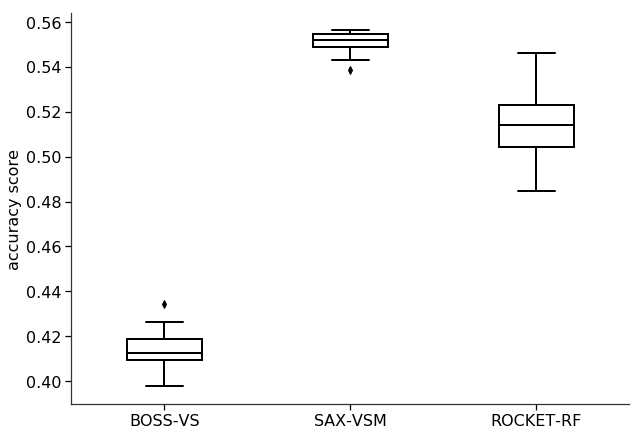

In [55]:
scores_df = pd.DataFrame({
    'accuracy score': list(itertools.chain(*[classifier_scores[model_name].acc 
                                             for model_name in models_dict])),
    'model': list(itertools.chain(*[[model_name] * len(classifier_scores[model_name].acc) 
                                    for model_name in models_dict])),
})
    
boxplot(x='model', y='accuracy score', data=scores_df, notch=False)